In [1]:
import os
import numpy as np
from alignment_helper_fns import *
from audio_utils import *

audio_dir = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'
manual_textgrids_dir = '/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/'
mfa_sat_dir = '/home/prad/datasets/ChildSpeechDataset/mfa_adapted/'
# mfa_sat_dir = '/home/prad/datasets/ChildSpeechDataset/mfa_with_sat/'

unmatched_manual_textgrid_files = get_all_textgrids_in_directory(manual_textgrids_dir)
aligner_textgrid_files = get_all_textgrids_in_directory(mfa_sat_dir)
candidate_aligner_textgrid_files = get_all_textgrids_in_directory(mfa_sat_dir)
manual_textgrid_files = []
audio_files = ['/'.join([audio_dir,_path.split('/')[-2], _path.split('/')[-1][:-8]+'wav'])
               for _path in unmatched_manual_textgrid_files]

from create_child_speech_dataset import *
from gop_helper_fns import *

'''
need to match the corresponding files since the files loaded from the code above are out of order
'''
mismatched_phoneme = 0
mismatched_lengths = 0
print(len(aligner_textgrid_files))
for ii, aligned_tg_file in tqdm.tqdm(enumerate(aligner_textgrid_files)):
#     print(ii)
    _filename = aligned_tg_file.split('/')[-1].replace('-', '_')
#     print(_filename)
    matching_ind = int(np.argwhere([_filename in manual_file for manual_file in unmatched_manual_textgrid_files]).ravel())
#     print(matching_ind)
    matching_gt_file = unmatched_manual_textgrid_files[matching_ind]
    manual_textgrid_files.append(matching_gt_file)

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/


43it [00:00, 4051.92it/s]


Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/mfa_adapted/


43it [00:00, 5008.33it/s]


Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/mfa_adapted/


43it [00:00, 6931.40it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


3764


3764it [00:01, 2218.81it/s]


In [3]:
transcripts = {}
for filename in audio_files:
    fname = filename.split('/')[-1]
    # speaker_dir = filename.split('/')[-2]
    # print(fname)
    # fname = os.path.join(manual_textgrids_dir, speaker_dir, fname[:-8]+'lab')
    fname = filename[:-3] + 'lab'
    # print(fname)
    # break
    f = open(fname)
    _transcript = f.read()
    # print(_transcript)
    transcripts[filename] = _transcript[:-1]

In [10]:
# from gop_helper_fns import *
artps = []
artps_phonewise = []
dct = {'filename': [], 'speaker': [], 'transcript': [], 'PLLR': []}
# dct['filename':audiofname, 'speaker': speaker_dir, 'transcript': _transcript: 'PLLR': _artp]

for ii, tgfilepath in enumerate(tqdm.tqdm(manual_textgrid_files)):
    audiofname = tgfilepath.split('/')[-1][:-8] + 'wav'
    speaker_dir = tgfilepath.split('/')[-2]
    audio_path = audio_files[ii]
    _transcript = transcripts[audio_path]
    try:
    #pd.DataFrame(charsiu.align(audio=audio_path,text=_transcript)[0])
        _artp, _artp_phonewise = calculate_GOP_e2e(audio=audio_path, transcript=_transcript)
        artps.append(_artp)
        artps_phonewise.append(_artp_phonewise)
        dct['filename'].append(audiofname)
        dct['speaker'].append(speaker_dir)
        dct['transcript'].append(_transcript)
        dct['PLLR'].append(_artp)
    except:
    # print('Exception for \t', audio_path)
        artps.append(np.nan)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3764/3764 [03:08<00:00, 20.01it/s]


In [41]:
len(dct['filename'])

3763

In [15]:
asdf = pd.DataFrame.from_dict(dct)

In [18]:
asdf['PLLR'].iloc[0]

,Phone,GOP,NumFramesDuration
0,IY,-3.334041,33
1,D,0.000000,32


In [28]:
import pickle as pkl
pkl.dump(dct, open('pllrs.pkl', 'wb'))

In [31]:
qwer = pkl.load(open('pllrs.pkl', 'rb'))

In [37]:
qwer['PLLR'][0]

,Phone,GOP,NumFramesDuration
0,IY,-3.334041,33
1,D,0.000000,32


In [19]:
asdf.to_csv('pllrs.csv')

In [20]:
qwer = pd.read_csv('pllrs.csv')

In [ ]:
kaldi_artp_base = []
os.environ['KALDI_ROOT'] = '/home/prad/github/pykaldi/tools/kaldi'
os.environ['KALDI_LANGUAGE_MODEL_DIR'] = '/home/prad/github/speech-metrics/languagemodels'
from speechmetrics.artp_engine.artp2asr_metrics_computer import Artp2ASRAllMean
from metrics_core.computers.result_cache import ResultCache
from metrics_core.audio import Audio

# def get_speechbounds(aligned_df):
    # pass
for ii, tgfilepath in enumerate(tqdm.tqdm(manual_textgrid_files)):
    audiofname = tgfilepath.split('/')[-1][:-8] + 'wav'
    speaker_dir = tgfilepath.split('/')[-2]
    audio_path = audio_files[ii]
    _transcript = transcripts[audio_path]
    _audio = Audio.from_wav_file(audio_path)
    aligned_df = textgridpath_to_phonedf(tgfilepath, phone_key='ha phones')
    speechbounds = [aligned_df.iloc[0, 1], aligned_df.iloc[-1, 0]]
    try:
        _artp = Artp2ASRAllMean(ResultCache()).compute_inner(_audio, _transcript, speechbounds, 'en-us')
        kaldi_artp_base.append(_artp.value)
    except:
        print('Exception for \t:', audio_path)
        kaldi_artp_base.append(np.nan)

In [36]:
artps_ = []

for ap in artps:
    if type(ap)==float:
        artps_.append(0)
    else:
        artps_.append(ap['GOP'].values.mean())

In [34]:
artps_ = [ap_['GOP'].values.mean() for ap_ in artps]

TypeError: 'float' object is not subscriptable

In [22]:
for ii, tgfilepath in enumerate(tqdm.tqdm(manual_textgrid_files)):
    audiofname = tgfilepath.split('/')[-1][:-8] + 'wav'
    speaker_dir = tgfilepath.split('/')[-2]
    audio_path = audio_files[ii]
    _transcript = transcripts[audio_path]
    # _audio = Audio.from_wav_file(audio_path)
    speechbounds = [aligned_df.iloc[0, 1], aligned_df.iloc[-1, 0]]
    aligned_df = textgridpath_to_phonedf(tgfilepath, phone_key='ha phones')
    if aligned_df.iloc[-1, 2]!='sil':
        print(aligned_df.iloc[-1, 2])

 18%|█▊        | 693/3764 [00:00<00:02, 1171.99it/s]

IY0sil


100%|██████████| 3764/3764 [00:03<00:00, 990.63it/s] 


In [ ]:
''' from manual alignments '''
artps_manual_align = []
artps_manual_align_phonewise = []
for ii, tgfilepath in enumerate(tqdm.tqdm(manual_textgrid_files)):
    audiofname = tgfilepath.split('/')[-1][:-8] + 'wav'
    speaker_dir = tgfilepath.split('/')[-2]
    audio_path = audio_files[ii]
    tgfilename = tgfilepath.split('/')[-1]

    aligned_phones = textgridpath_to_phonedf(tgfilepath, phone_key='ha phones')
    aligned_phones = list(aligned_phones.to_records())
    aligned_phones = textgridpath_to_phonedf(tgfilepath, phone_key='ha phones', remove_numbers=True)
    aligned_phones.iloc[:, 2] = aligned_phones.iloc[:, 2].str.replace('sil', '[SIL]')
    aligned_phones = list(aligned_phones.to_records(index=False))
    _transcript = transcripts[audio_path]
    # try:
        #pd.DataFrame(charsiu.align(audio=audio_path,text=_transcript)[0])
    _artp, _artp_manual_align_phonewise = calculate_GOP_e2e(audio_filepath=audio_path, transcript=_transcript, aligned_phones=aligned_phones)
    artps_manual_align.append(_artp)
    artps_manual_align_phonewise.append(_artp_manual_align_phonewise)
    # except:
    # print('Exception for \t', audio_path)
    # artps_manual_align.append(np.nan)

# artp_df.to_csv('./child_speech_gops.csv')

In [ ]:
artp_df['gop_manual_align'] = artps_manual_align


In [5]:
# from gop_helper_fns import *
artps_finetune_align = []
artps_phonewise_finetune_align = []

for ii, tgfilepath in enumerate(tqdm.tqdm(manual_textgrid_files)):
    audiofname = tgfilepath.split('/')[-1][:-8] + 'wav'
    speaker_dir = tgfilepath.split('/')[-2]
    audio_path = audio_files[ii]
    tgfilename = tgfilepath.split('/')[-1]
    
    output_tg_dir = os.path.join('results_frame_10epochs/', speaker_dir)

    tg_filepath = os.path.join(output_tg_dir, tgfilename)
    
    if os.path.exists(tg_filepath):
        aligned_phones = textgridpath_to_phonedf(tg_filepath, phone_key='phones', remove_numbers=True)
        aligned_phones.iloc[:, 2] = aligned_phones.iloc[:, 2].str.replace('sil', '[SIL]')
        aligned_phones = list(aligned_phones.to_records(index=False))
    else:
        aligned_phones = None
    
    _transcript = transcripts[audio_path]
    try:
        #pd.DataFrame(charsiu.align(audio=audio_path,text=_transcript)[0])
        _artp, _artp_phonewise = calculate_GOP_e2e(audio_filepath=audio_path, transcript=_transcript, aligned_phones=aligned_phones)
        artps_finetune_align.append(_artp)
        artps_phonewise_finetune_align.append(_artp_phonewise)
    except:
        print('Exception for \t', audio_path)
        artps_finetune_align.append(np.nan)

 91%|█████████ | 3414/3764 [03:02<00:16, 21.43it/s]

Exception for 	 /home/prad/datasets/ChildSpeechDataset/child_speech_16_khz/0411_M_LM/0411_M_LMwT32.wav


100%|██████████| 3764/3764 [03:21<00:00, 18.68it/s]


In [5]:
artp_df = pd.read_csv('./child_speech_gops.csv')

In [6]:
artp_df['gop']
artps_finetune_align = artp_df['gop_finetune_align']
artp_df['kaldi_artp_base']

,Unnamed: 0,audio_file,gops,gop_finetune_align,kaldi_artp_base,age
0,0,/home/prad/datasets/ChildSpeechDataset/child_s...,-1.666988,-0.992144,-4.700816,4.583333
1,1,/home/prad/datasets/ChildSpeechDataset/child_s...,-2.302717,-3.012585,-3.273083,4.583333
2,2,/home/prad/datasets/ChildSpeechDataset/child_s...,-3.021064,-3.289559,-2.652313,4.583333
3,3,/home/prad/datasets/ChildSpeechDataset/child_s...,-0.925089,-1.294149,-3.197263,4.583333
4,4,/home/prad/datasets/ChildSpeechDataset/child_s...,-3.328215,-3.446891,-1.836201,4.583333
...,...,...,...,...,...,...
3759,3759,/home/prad/datasets/ChildSpeechDataset/child_s...,-1.007872,-1.303889,-3.634736,5.000000
3760,3760,/home/prad/datasets/ChildSpeechDataset/child_s...,-2.665548,-2.692835,-1.039916,5.000000
3761,3761,/home/prad/datasets/ChildSpeechDataset/child_s...,-1.113017,-1.414474,-1.587672,5.000000
3762,3762,/home/prad/datasets/ChildSpeechDataset/child_s...,-2.373096,-4.196033,-0.565982,5.000000


In [7]:
artp_df = pd.DataFrame([(af, ap) for af, ap in zip(audio_files, artps)], columns=['audio_file', 'gops'])
artp_df['gop_finetune_align'] = artps_finetune_align
artp_df['kaldi_artp_base'] = kaldi_artp_base
def get_age_from_audiofname(audiofname):
    ageinfo = audiofname.split('/')[-1].split('_')[0]
    years = float(ageinfo[:2])
    months = float(ageinfo[2:])
    return years + months/12
artp_df['age'] = artp_df.apply(lambda x: get_age_from_audiofname(x['audio_file']), axis=1)

# artp_df.to_csv('./child_speech_gops.csv')

Text(0, 0.5, 'GOP Base Aligner')

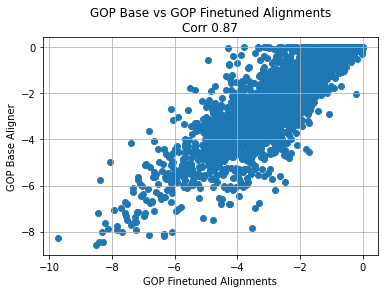

In [11]:
import matplotlib.pyplot as plt
plt.title('GOP Base vs GOP Finetuned Alignments\nCorr %.2f' % artp_df['gop_finetune_align'].corr(artp_df['gops']))
plt.scatter(artp_df['gop_finetune_align'], artp_df['gops'])
plt.grid()
plt.xlabel('GOP Finetuned Alignments')
plt.ylabel('GOP Base Aligner')

Text(0, 0.5, 'GOP Finetuned Alignments')

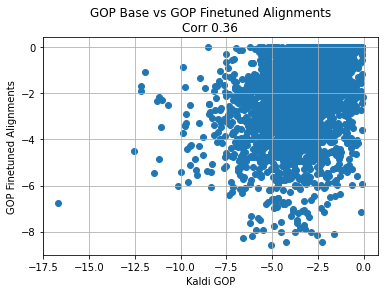

In [20]:
import matplotlib.pyplot as plt
plt.title('GOP Base vs GOP Finetuned Alignments\nCorr %.2f' % artp_df['kaldi_artp_base'].corr(artp_df['gops']))
plt.scatter(artp_df['kaldi_artp_base'], artp_df['gops'])
plt.grid()
plt.xlabel('Kaldi GOP')
plt.ylabel('GOP Finetuned Alignments')

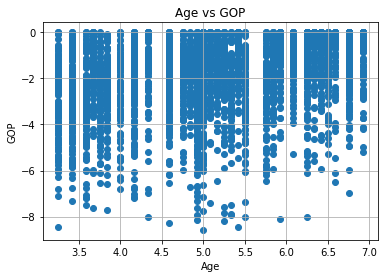

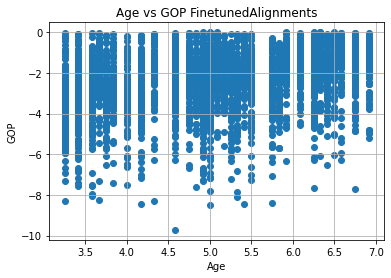

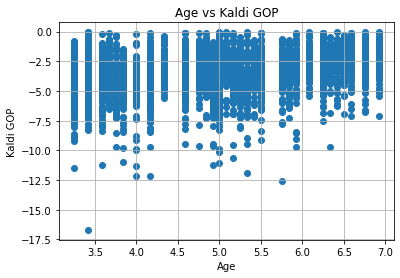

In [14]:
plt.figure()
plt.scatter(artp_df['age'], artp_df['gops'])
plt.title('Age vs GOP')
plt.xlabel('Age')
plt.ylabel('GOP')
plt.grid()
plt.figure()
plt.scatter(artp_df['age'], artp_df['gop_finetune_align'])
plt.title('Age vs GOP FinetunedAlignments')
plt.xlabel('Age')
plt.ylabel('GOP')
plt.grid()

plt.figure()
plt.scatter(artp_df['age'], artp_df['kaldi_artp_base'])
plt.title('Age vs Kaldi GOP')
plt.xlabel('Age')
plt.ylabel('Kaldi GOP')
plt.grid()

<Figure size 432x288 with 0 Axes>

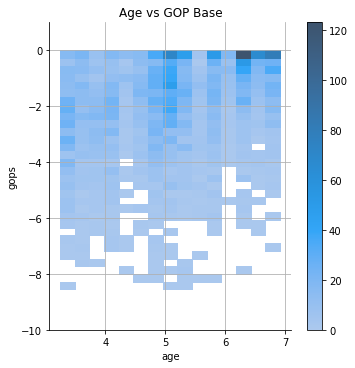

<Figure size 432x288 with 0 Axes>

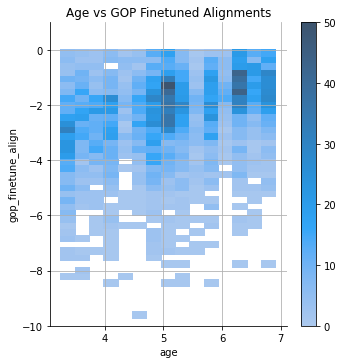

<Figure size 432x288 with 0 Axes>

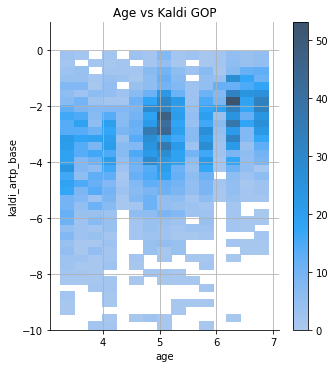

In [15]:
import seaborn as sns
plt.figure()
sns.displot(artp_df, x="age", y="gops",  cbar=True)
plt.title('Age vs GOP Base')
plt.ylim([-10, 1])
plt.grid()

plt.figure()
sns.displot(artp_df, x="age", y="gop_finetune_align",  cbar=True)
plt.title('Age vs GOP Finetuned Alignments')
plt.ylim([-10, 1])
plt.grid()

plt.figure()
sns.displot(artp_df, x="age", y="kaldi_artp_base",  cbar=True)
plt.title('Age vs Kaldi GOP')
plt.ylim([-10, 1])
plt.grid()


In [16]:
artp_df['age'].corr(artp_df['kaldi_artp_base'])

0.31644650621176346

TypeError: The y variable is categorical, but one of ['numeric', 'datetime'] is required

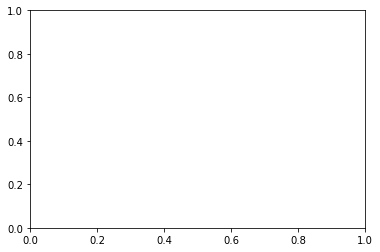

In [27]:
sns.kdeplot(x=artp_df['age'].values, y=artps, fill=True, cmap='viridis', cbar=True)

(-8.0, 1.0)

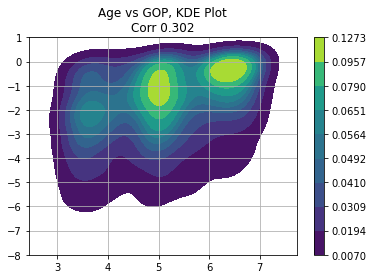

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.kdeplot(x=artp_df["age"].values, y=artps_, fill=True, cmap='viridis', cbar=True)
corrval = artp_df['age'].corr(artp_df['gops'])
plt.title('Age vs GOP, KDE Plot\nCorr %.3f' % corrval)
plt.grid()
plt.ylim([-8, 1])

(-8.0, 1.0)

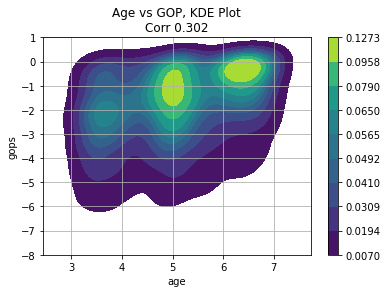

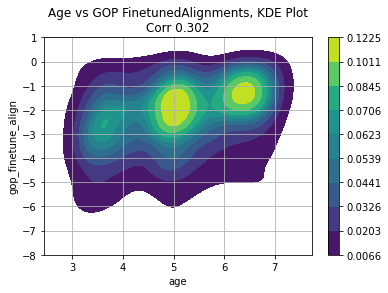

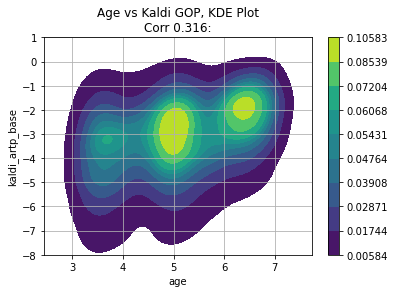

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.kdeplot(x=artp_df["age"], y=artp_df["gops"], fill=True, cmap='viridis', cbar=True)
corrval = artp_df['age'].corr(artp_df['gops'])
plt.title('Age vs GOP, KDE Plot\nCorr %.3f' % corrval)
plt.grid()
plt.ylim([-8, 1])

plt.figure()
sns.kdeplot(x=artp_df["age"], y=artp_df["gop_finetune_align"], fill=True, cmap='viridis', cbar=True)
corrval = artp_df['age'].corr(artp_df['gop_finetune_align'])
plt.title('Age vs GOP FinetunedAlignments, KDE Plot\nCorr %.3f' % corrval)
# plt.title('Age vs Kaldi GOP, KDE Plot\nCorr %.2f:')
plt.grid()
plt.ylim([-8, 1])

plt.figure()
sns.kdeplot(x=artp_df["age"], y=artp_df["kaldi_artp_base"], fill=True, cmap='viridis', cbar=True)
corrval = artp_df['age'].corr(artp_df['kaldi_artp_base'])
plt.title('Age vs Kaldi GOP, KDE Plot\nCorr %.3f:' % corrval)
plt.grid()
plt.ylim([-8, 1])


In [30]:
tgfilepath.split('/')[-1][:-8] + 'wav'


'0407_M_SJs2T05.wav'

In [34]:
''' '''
idx = 1
tgfilepath = manual_textgrid_files[1]
speaker_dir = tgfilepath.split('/')[-2]
tgfilename = tgfilepath.split('/')[-1]
output_tg_dir = os.path.join('results_frame_10epochs/', speaker_dir)
tg_filepath = os.path.join(output_tg_dir, tgfilename)
print(transcripts[ audio_files[idx]])
print(textgridpath_to_phonedf(tg_filepath, phone_key='phones'))

print(artps_phonewise_finetune_align[1])
print(audio_files[idx])
Aud(filename=audio_files[idx], rate=16000)

ANIMAL CRACKERS
       0     1    2
0   0.00  0.37  sil
1   0.37  0.45   AE
2   0.45  0.50    N
3   0.50  0.55   AH
4   0.55  0.65    M
5   0.65  0.68   AH
6   0.68  0.82    L
7   0.82  0.86    K
8   0.86  0.95    R
9   0.95  1.11   AE
10  1.11  1.16    K
11  1.16  1.39   ER
12  1.39  1.60    Z
13  1.60  2.01  sil
  Phone       GOP
0     M -0.195053
1    AE -3.767449
2     R -0.365895
3     N -5.536468
4    ER -5.630128
5     Z -5.150868
6     K -1.122888
7    AH -2.149651
8     L -3.194863
/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz/0407_M_SJ/0407_M_SJs2T05.wav


In [68]:
aligned_phones = textgridpath_to_phonedf(manual_textgrid_files[0], phone_key='ha phones', remove_numbers=True)
aligned_phones.iloc[:, 2] = aligned_phones.iloc[:, 2].str.replace('sil', '[SIL]')
aligned_phones = list(aligned_phones.to_records())
aligned_phones

[(0, 0., 0.36261359, '[SIL]'),
 (1, 0.36261359, 0.58, 'D'),
 (2, 0.58, 0.95883058, 'IY'),
 (3, 0.95883058, 1.31, '[SIL]')]

In [66]:
aligned_phones = textgridpath_to_phonedf(manual_textgrid_files[0], phone_key='ha phones', remove_numbers=True)
aligned_phones.iloc[:,2].str.replace('sil', '[SIL]')

0    [SIL]
1        D
2       IY
3    [SIL]
Name: 2, dtype: object

In [41]:
allphones = []
[[allphones.append(phn) for phn in list(phonewise_df['Phone'].values)] for phonewise_df in artps_phonewise_finetune_align]
np.unique(allphones)

array(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH',
       'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N',
       'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V',
       'W', 'Y', 'Z'], dtype='<U2')

In [ ]:
''' Inter-rater agreement '''

In [ ]:
''' Per-phone accuracy '''


In [44]:
phones = []
unkowncategory = ['L', 'R', 'V', 'W']
nasal = ['M', 'N', 'NG']
plosives = ['B', 'D', 'DH', 'G', 'JH', 'K', 'P', 'T', 'TH']
vowels = ['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'ER', 'EY', 'IY', 'UH', 'OW', 'OY', 'UH', 'UW', 'Y']
fricatives = ['CH', 'F', 'H', 'S', 'SH', 'Z']
difficult_phones = ['L', 'R', 'S', 'TH', 'Z']

In [ ]:
''' Per phone artp trajectory '''

# def get_artp_phone_by_age(phone):
    
